In [7]:
import numpy as np
import scipy 

Ku = 0
mu0 = 4e-7 * np.pi
Ms1 = 1.21e6
Ms2 = 1.21e6
d1 = 15e-9
d2 = 15e-9
thH = 0

In [29]:
def y(vars):
    x, z = vars
    return x**2 + x + x* z + (x-1)*(z+1) , x

initial_guess = np.array([1,1])
sol = scipy.optimize.root(y, initial_guess)
y(sol.x)


(np.float64(0.0), np.float64(5.442641911651871e-30))

In [ ]:
from numpy import sin, cos
μ0 = mu0
J = 1e-11
Ms = 7e5
d = 2e-9
N = 4
kr = np.eye(N+1)
def eq_condition(self, H0, th0, phi0, initial_guess = np.array([2*np.pi for i in range(2*N)])):
    # th = [th0, th1, ...] is an array of variables to obtain
    # same as phi = [phi0, phi1, ...]

    # Zeeman
    def H_ext(nu, H0, th0, phi0, th, phi):
        HX = H0 *( sin(th[nu])*sin(phi[nu]-phi0) )
        HY = H0 *( sin(th[nu])*sin(th0) - cos(th[nu])*cos(th0)*cos(phi[nu]-phi0) )
        return HX, HY
    
    # Dipolar
    def H_dip(nu, th):
        HY = - Ms*cos(th[nu])*sin(th[nu])
        HX = 0
        return HX, HY
    
    # Exchange
    def H_ex(nu, th, phi):
        

        HX = -sum(J/(μ0*Ms*d) * (kr[nu+1,p]+kr[nu,p+1]) * sin(th[nu])*sin(phi[nu]-phi[p]) for p in range(N))
        HY = sum(J/(μ0*Ms*d) * (kr[nu+1,p]+kr[nu,p+1]) * ( sin(th[nu])*cos(th[p]) - cos(phi[nu]-phi[p])*cos(th[nu]*sin(th[p])) ) for p in range(N))
        return HX, HY
    
    def Heq(vars_flat, N):
        th = vars_flat[:N]
        phi = vars_flat[N:]
        HeqX = np.zeros(N)
        HeqY = np.zeros(N)

        for nu in range(N):
            H0X, H0Y = H_ext(nu, H0, th0, phi0, th, phi)
            HdipX, HdipY = H_dip(nu, th)
            HexX, HexY = H_ex(nu, th, phi)

            HeqX[nu] = H0X + HdipX + HexX
            HeqY[nu] = H0Y + HdipY + HexY
                
        return np.concatenate([HeqX, HeqY])
    
    sol = scipy.optimize.root(Heq, np.concatenate([np.full(N, th0), np.full(N, phi0)]), args=(N,))

# Definitions

The numerical eqn to solve is to minimize the energy

$$
 E = K_u (d_1 \sin^2\psi_1 + d_2\sin^2\psi_2) - \mu_0  H [d_1M_s^1\cos(\theta_H-\psi_1)+d_2M_s^2\cos(\theta_H-\psi_2)] - J_1 \cos(\psi_1-\psi_2) - J_2 \cos^2(\psi_1-\psi_2)
$$ 

In [11]:
def energy(psi1, psi2, J1, J2, H):
    term1 = Ku * (d1*np.sin(psi1)**2 + d2*np.sin(psi2)**2)
    term2 = - mu0 * H * (d1*Ms1*np.cos(thH - psi1) + d2*Ms2*np.cos(thH - psi2))
    term3 = - J1 * np.cos(psi1 - psi2)- J2 * np.cos(psi1 - psi2)**2

    return (term1 + term2 + term3)/((d1 + d2)*mu0*((Ms1 + Ms2)/2)**2)

Minimze allows to minimize one or more variable functions. Allows for different methods and gives the point
- res.x = x value that minimizes f
- res.fun = minimum f value at res.x
- can take multi-variable functions
- Example usage : 

In [12]:
from scipy.optimize import minimize

def f(v):
    x = v[0]
    y = v[1]
    return y* np.cos(x**2+y) + np.sin(x)*np.sin(3*x)*(1-x)**x

res = minimize(f, x0=[1e-2,2], method='L-BFGS-B', bounds=None)
print(res)

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: -3.288371395590855
        x: [ 1.007e-07  3.426e+00]
      nit: 7
      jac: [ 8.882e-07 -8.882e-08]
     nfev: 27
     njev: 9
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


In [13]:
from scipy.optimize import minimize
from numpy import pi 

def minimize_energy(J1, J2, H, initial_guesses=None, bounds=None, method='L-BFGS-B', n_restarts=25):

    if initial_guesses is None:
        # a set of deterministic starting points + some random
        grid = [(0,0), (pi/2, pi/2), (pi, -pi/2), (-pi/2, pi/4)]
        rng = np.random.RandomState(0)
        for _ in range(max(0, n_restarts - len(grid))):
            grid.append((rng.uniform(-pi,pi), rng.uniform(-pi,pi)))
        initial_guesses = grid

    best = {'Emin': np.inf, 'psi1': None, 'psi2': None, 'success': False}
    for x0 in initial_guesses:
        def f(x):
            return energy(x[0], x[1], J1, J2, H)

        # bounds for psi angles if provided
        res = minimize(f, x0=np.array(x0), method=method, bounds=bounds)
        if res.success and res.fun < best['Emin'] - 1e-7:
            best.update({'Emin': float(res.fun), 'psi1': float(res.x[0]), 'psi2': float(res.x[1]), 'success': True})
        elif not res.success:
            # keep the value anyway in case it's lower
            if res.fun < best['Emin']:
                best.update({'Emin': float(res.fun), 'psi1': float(res.x[0]), 'psi2': float(res.x[1]), 'success': False})

    return best

In [ ]:
np

In [14]:
from scipy.optimize import least_squares

m_mean = ( Ms1*d1  + Ms2*d2 )/(d1+d2)

# this is the observable that I can fit with the experimental data in Ms units
def observable(res):
    psi1 = res['psi1']
    psi2 = res['psi2']
    m = Ms1 *d1/(d1+d2) * np.cos(psi1-thH) + Ms2 *d2/(d1+d2)*np.cos(psi2-thH) 
    return m

# residuals function for least squares fitting
def residuals_for_fit(J, H_exp, M_exp):
    J1, J2 = J
    res_list = []

    # for each H in the list of experimental measurements H_exp, compute the calculated M and compare with M_exp
    for i, H in enumerate(H_exp):
        min_res = minimize_energy(J1, J2, H)
        M_calc = observable(min_res)
        M_sim = M_exp[i]
        
        res_list.append(((M_calc - M_sim)/m_mean)**2)  # difference
    
    return np.array(res_list)


In [15]:
from scipy.optimize import differential_evolution

def best_J(lower_bounds, upper_bounds, h_vals, m_vals):
    def cost(J):
        return np.sum(residuals_for_fit(J, h_vals, m_vals))
    
    result = differential_evolution(cost, bounds=list(zip(lower_bounds, upper_bounds)), maxiter=30, popsize=8)
    status_global = result

    guess = result.x

    refined_result = least_squares(
        residuals_for_fit,
        x0=guess,
        bounds=(lower_bounds, upper_bounds),
        args=(h_vals, m_vals),
        xtol=1e-7,
        ftol=1e-7,
        max_nfev=5000
    )
    
    
    status_refined = refined_result
    best_params = refined_result.x

    return best_params , status_global, status_refined

In [16]:
def hystersis(h_vals, J1, J2):
    m_vals = []
    psi1_vals = []
    psi2_vals = []
    for H in h_vals:
        res = minimize_energy(J1, J2, H)
        m = observable(res)
        m_vals.append(m)

        psi1 = res['psi1']
        psi1 = psi1 % ( 2* np.pi)
        psi2 = res['psi2']
        psi2 = psi2 % ( 2* np.pi)

        psi1_vals.append(psi1)
        psi2_vals.append(psi2)


    return np.array(m_vals), np.array(psi1_vals), np.array(psi2_vals)

# Calculations

In [ ]:
hmax = 350e-3/mu0 # (T)
H_vals = np.linspace(.5e-3/mu0, hmax, 100)
J1 = -9.1e-4
J2 = 0
Ku =  0
mx_num, psi1_vals, psi2_vals = hystersis(H_vals, J1, J2)

In [19]:
np.savez("d1=15_d2=15_rkk=-9.1e-4", H_vals=H_vals, psi1_vals=psi1_vals, psi2_vals=psi2_vals)

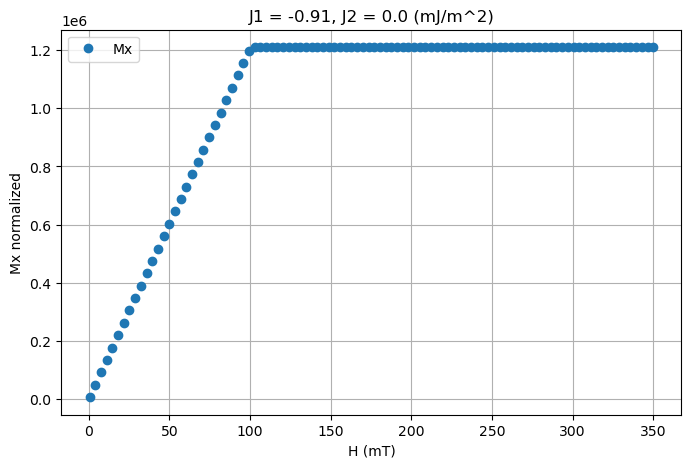

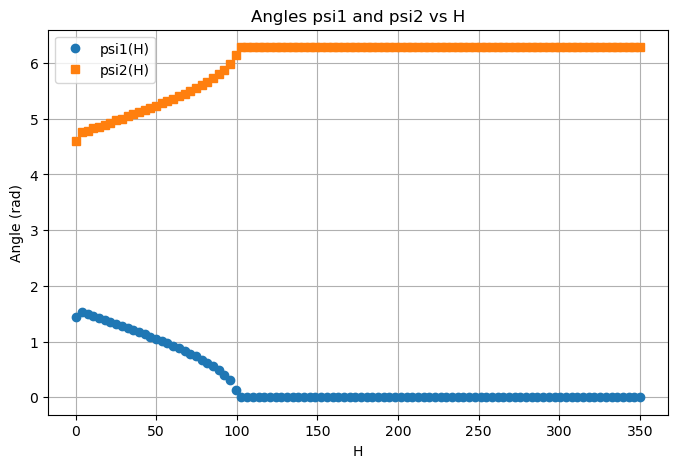

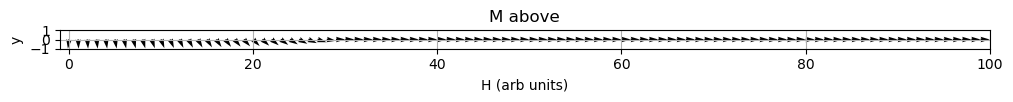

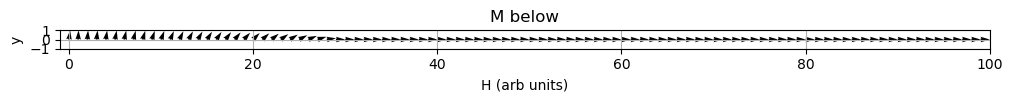

In [18]:
import matplotlib.pyplot as plt


# Plot magnetization
plt.figure(figsize=(8,5))
plt.plot(H_vals*mu0*1e3, mx_num, 'o', label='Mx')
plt.xlabel('H (mT)')
plt.ylabel('Mx normalized')
plt.title(f'J1 = {round(J1*1e3,3)}, J2 = {round(J2*1e3,3)} (mJ/m^2)')
plt.grid(True)
plt.legend()
plt.show()

psi1_mod = []
sim_axis = np.pi
for psi in psi1_vals:
    if psi > sim_axis:
        psi1_mod.append(sim_axis-(psi-sim_axis))
    else:
        psi1_mod.append(psi)

psi2_mod = []
for psi in psi2_vals:
    if psi < sim_axis:
        psi2_mod.append(sim_axis+(sim_axis-psi))
    else:
        psi2_mod.append(psi)
'''
#Optional: plot psi1 and psi2 vs H
plt.figure(figsize=(8,5))
plt.plot(H_vals, psi1_vals, 'o', label='psi1(H)')
plt.plot(H_vals, psi2_vals, 's', label='psi2(H)')
plt.xlabel('H')
plt.ylabel('Angle (rad)')
plt.title('Angles psi1 and psi2 vs H')
plt.grid(True)
plt.legend()
plt.show()

'''
# Optional: plot psi1 and psi2 vs H
plt.figure(figsize=(8,5))
plt.plot(H_vals*mu0*1e3, psi1_mod, 'o', label='psi1(H)')
plt.plot(H_vals*mu0*1e3, psi2_mod, 's', label='psi2(H)')
plt.xlabel('H')
plt.ylabel('Angle (rad)')
plt.title('Angles psi1 and psi2 vs H')
plt.grid(True)
plt.legend()
plt.show()

# Compute arrow components
u = np.cos(psi1_mod)   # x-components
v = np.sin(psi1_mod)   # y-components

# Arrow origins: spread along x-direction
x0 = np.arange(len(psi1_mod))
y0 = np.zeros_like(psi1_mod)

u2 = np.cos(psi2_mod)   # x-components
v2 = np.sin(psi2_mod)   # y-components

# Arrow origins: spread along x-direction
x02 = np.arange(len(psi2_mod))
y02 = np.zeros_like(psi2_mod)


plt.figure(figsize=(12, 3))
plt.quiver(x02, y02, u2, v2, angles='xy', scale_units='xy', scale=1)
plt.xlim(-1, len(psi1_mod))
plt.ylim(-1, 1)
plt.gca().set_aspect('equal')
plt.title("M above")
plt.xlabel("H (arb units)")
plt.ylabel("y")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 3))
plt.quiver(x0, y0, u, v, angles='xy', scale_units='xy', scale=1)
plt.xlim(-1, len(psi1_mod))
plt.ylim(-1, 1)
plt.gca().set_aspect('equal')
plt.title("M below")
plt.xlabel("H (arb units)")
plt.ylabel("y")
plt.grid(True)
plt.show()